# Pre-process Tweets for Marriott Hotels

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

import re 
from string import punctuation
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

import joblib
import pickle

from nltk.probability import FreqDist

import matplotlib.pyplot as plt
%matplotlib inline

import plotly
import plotly_express as px

import warnings
warnings.filterwarnings('ignore')

print('All Libraries Imported')

All Libraries Imported


In [2]:
pd.set_option('display.max_colwidth', 2000)

## Import Tweets

In [3]:
df = pd.read_csv("hotel_tweets.csv")
display(df.head())
display(df.info())
display(round(df.describe(),2))

,Created At,Hotel,Text
0,2019-12-13 14:47:03,Stregis,Polo anyone?\r\n#StRegis World Snow #Polo Championship will be held on December 18-20 at the #AspenValleyPoloClub.\r\n\r\nhttps://t.co/jz6r5t8YnN\r\n\r\n#RWayneLopez #PoloEvent #StRegis #StRegisAspen #StRegisHotels #RichardMille #StRegisResidencesBoston #RioGrandePark #FlexJet https://t.co/8zWTL21uJL
1,2019-12-13 13:05:34,Stregis,Fantastic night at the @TheStRegisMC celebrating is 10th #Anniversary \r\n#StRegis https://t.co/teQWnFtTCn
2,2019-12-13 09:16:46,Stregis,"It's the exceptional tropical sunshine that ensures ultimate relaxation at The St. Regis Bali Resort. Enjoy an exquisite vacation with up to 20% off when booking 60 days in advance.\r\n——\r\nFor further information, click: https://t.co/rKK5O4ZBYh\r\n#StRegisBali #StRegis #LiveExquisite https://t.co/3TdmaHYLJP"
3,2019-12-13 04:05:43,Stregis,This is 38. 🎂🏹👀😬🍺🍰💩 @stregisaspen #birthday #🎂 #🍰 #sagittarius #1212 #🏹 #stregis #aspen #ilovemylife #happybirthday #velvetbuckaspen https://t.co/f7ZKRuUjop
4,2019-12-13 00:14:04,Stregis,"Stunning overwater bar you will see today! It's called 🐳""Whale Bar""🐳. \r\n\r\nAn overwater lounge where you can enjoy delectable tapas &amp; locally sourced seafood as well as hand-picked wines and spirits while relaxing your eyes, mind, and body facing the ocean.\r\n#StRegis #madlymaldives https://t.co/lqrdk5YsO6"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14581 entries, 0 to 14580
Data columns (total 3 columns):
Created At    14581 non-null object
Hotel         14581 non-null object
Text          14581 non-null object
dtypes: object(3)
memory usage: 341.8+ KB


None

,Created At,Hotel,Text
count,14581,14581,14581
unique,13991,11,12915
top,2019-12-11 16:15:06,Marriott,Thanks Marriott! #MembersGetIt #RewardsPoints #FindYourRoute #MRpoints
freq,4,10000,192


In [4]:
df.rename(columns={'Text':'Tweets'},inplace=True)

In [5]:
rows,cols = df.shape
print("Number of rows: ", rows)
print("Number of columns: ", cols)

Number of rows:  14581
Number of columns:  3


In [6]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
Tweets,0,0.0
Hotel,0,0.0
Created At,0,0.0


## Sentiment Analysis

Tweets will be analyzed to determine the emotional tone they carry. VADER will be used to sort the tweets into positive, neutral and negative sentiment. TextBlob will be used to grade the subjectivity of the tweets, determining if they are based on facts or opinions. 

In [7]:
#sentiment_score VADER
df['Sentiment_VADER'] = df['Tweets'].map(lambda text: SentimentIntensityAnalyzer().polarity_scores(text)['compound'])

In [8]:
#sentiment score TextBlob
df['Sentiment_TextBlob'] = df['Tweets'].map(lambda text: TextBlob(text).sentiment.polarity)

In [9]:
#subejctivity TextBlob
df['Subjectivity'] = df['Tweets'].map(lambda text: TextBlob(text).sentiment.subjectivity)

In [10]:
df.head()

,Created At,Hotel,Tweets,Sentiment_VADER,Sentiment_TextBlob,Subjectivity
0,2019-12-13 14:47:03,Stregis,Polo anyone?\r\n#StRegis World Snow #Polo Championship will be held on December 18-20 at the #AspenValleyPoloClub.\r\n\r\nhttps://t.co/jz6r5t8YnN\r\n\r\n#RWayneLopez #PoloEvent #StRegis #StRegisAspen #StRegisHotels #RichardMille #StRegisResidencesBoston #RioGrandePark #FlexJet https://t.co/8zWTL21uJL,0.4404,0.000000,0.0
1,2019-12-13 13:05:34,Stregis,Fantastic night at the @TheStRegisMC celebrating is 10th #Anniversary \r\n#StRegis https://t.co/teQWnFtTCn,0.8074,0.400000,0.9
2,2019-12-13 09:16:46,Stregis,"It's the exceptional tropical sunshine that ensures ultimate relaxation at The St. Regis Bali Resort. Enjoy an exquisite vacation with up to 20% off when booking 60 days in advance.\r\n——\r\nFor further information, click: https://t.co/rKK5O4ZBYh\r\n#StRegisBali #StRegis #LiveExquisite https://t.co/3TdmaHYLJP",0.8689,0.413333,0.8
3,2019-12-13 04:05:43,Stregis,This is 38. 🎂🏹👀😬🍺🍰💩 @stregisaspen #birthday #🎂 #🍰 #sagittarius #1212 #🏹 #stregis #aspen #ilovemylife #happybirthday #velvetbuckaspen https://t.co/f7ZKRuUjop,0.0000,0.000000,0.0
4,2019-12-13 00:14:04,Stregis,"Stunning overwater bar you will see today! It's called 🐳""Whale Bar""🐳. \r\n\r\nAn overwater lounge where you can enjoy delectable tapas &amp; locally sourced seafood as well as hand-picked wines and spirits while relaxing your eyes, mind, and body facing the ocean.\r\n#StRegis #madlymaldives https://t.co/lqrdk5YsO6",0.9359,0.341667,0.5


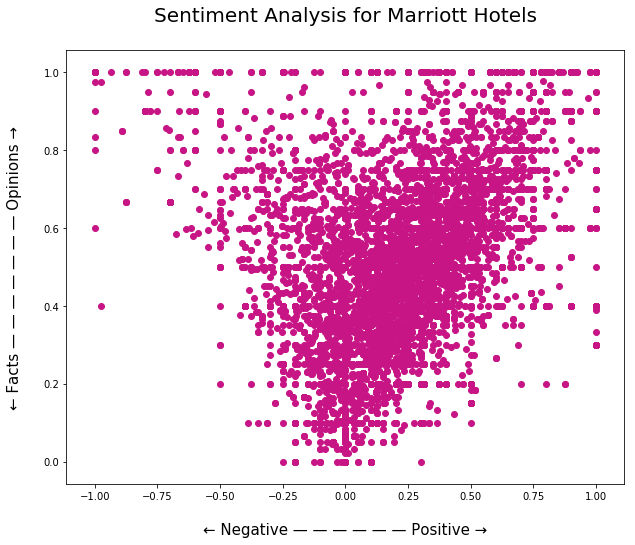

In [11]:
#plot subjectivity vs. polarity
plt.rcParams['figure.figsize'] = [10, 8]
for index, Tweets in enumerate(df.index):
    x = df['Sentiment_TextBlob'].loc[Tweets]
    y = df['Subjectivity'].loc[Tweets]
    plt.scatter(x, y, color='#C71585')

plt.title('Sentiment Analysis for Marriott Hotels\n', fontsize = 20)
plt.xlabel('\n← Negative — — — — — — Positive →', fontsize=15)
plt.ylabel('← Facts — — — — — — — Opinions →\n', fontsize=15)
plt.show()

In [12]:
#percentage positive,neutral, negative tweets for Marriott Hotels
positive_tweets = [ tweet for index, tweet in enumerate(df['Tweets']) if df['Sentiment_VADER'][index] > 0]
neutral_tweets = [ tweet for index, tweet in enumerate(df['Tweets']) if df['Sentiment_VADER'][index] == 0]
negative_tweets = [ tweet for index, tweet in enumerate(df['Tweets']) if df['Sentiment_VADER'][index] < 0]

In [13]:
print('Percentage Positive Tweets: {}%'.format(len(positive_tweets)*100/len(df['Tweets'])))
print('Percentage Neutral Tweets: {}%'.format(len(neutral_tweets)*100/len(df['Tweets'])))
print('Percentage Negative Tweets: {}%'.format(len(negative_tweets)*100/len(df['Tweets'])))

Percentage Positive Tweets: 59.07688087236815%
Percentage Neutral Tweets: 30.683766545504422%
Percentage Negative Tweets: 10.239352582127426%


In [14]:
df['Sentiment'] = df['Sentiment_VADER'].apply(lambda x: 'Positive' if x >= 0 else 'Negative')
df['Sentiment'] = df['Sentiment'].map({'Positive':1, 'Negative':0})

## Natural Language Processing

### Define List of Stopwords

In [15]:
stop_words = stopwords.words("english") 
stop_words += list(punctuation) 
stop_words += ["/n","''", '""', '...', '``',"'",'’','amp','&', '-','/','and','a', 'or', 'in','for',"n't"]
stop_words += ['stregis','jwmarriott','ritzcarlton','whotels', 'westin','sheraton','marriott','renaissancehotels',
               'residenceinn','fairfieldinn','springhillsuites','courtyardbymarriott','jw','hotel','ritz','carlton',
               '_zalokar','_fairfieldinn','priceline','expedia','booking.com','com']

### Process Tweets

1. Remove links, special characters, hashtags, user IDs and numbers
2. Make all text lower case
3. Create tokens 
4. Lemmatize tokens
5. Transform lemmatized tokens into a string for vectorization

### Clean and Tokenize Tweets

In [16]:
def clean_tweets(tweet):
    ''' 
    Utility function to clean tweet text by removing links, special characters 
    using simple regex statements. 
    '''
    tweet = re.sub(r'^RT[\s]+', '', tweet) #retweets removed
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet) #links removed
    tweet = re.sub(r'#', '', tweet) #hashtag removed
    tweet = re.sub(r'@[A-Za-z0–9]+', '', tweet) #user ID removed
    tweet = re.sub('[^a-zA-Z]', ' ', tweet)# numbers removed
    tweet = tweet.lower()
    tokens = nltk.word_tokenize(tweet)
    no_stopwords = [token for token in tokens if token not in stop_words]
    return no_stopwords

In [17]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [19]:
#clean_tweets()
df['cleaned_tweets'] = df['Tweets'].apply(clean_tweets)

In [20]:
df.head()

,Created At,Hotel,Tweets,Sentiment_VADER,Sentiment_TextBlob,Subjectivity,Sentiment,cleaned_tweets
0,2019-12-13 14:47:03,Stregis,Polo anyone?\r\n#StRegis World Snow #Polo Championship will be held on December 18-20 at the #AspenValleyPoloClub.\r\n\r\nhttps://t.co/jz6r5t8YnN\r\n\r\n#RWayneLopez #PoloEvent #StRegis #StRegisAspen #StRegisHotels #RichardMille #StRegisResidencesBoston #RioGrandePark #FlexJet https://t.co/8zWTL21uJL,0.4404,0.000000,0.0,1,"[polo, anyone, world, snow, polo, championship, held, december, aspenvalleypoloclub, rwaynelopez, poloevent, stregisaspen, stregishotels, richardmille, stregisresidencesboston, riograndepark, flexjet]"
1,2019-12-13 13:05:34,Stregis,Fantastic night at the @TheStRegisMC celebrating is 10th #Anniversary \r\n#StRegis https://t.co/teQWnFtTCn,0.8074,0.400000,0.9,1,"[fantastic, night, celebrating, th, anniversary]"
2,2019-12-13 09:16:46,Stregis,"It's the exceptional tropical sunshine that ensures ultimate relaxation at The St. Regis Bali Resort. Enjoy an exquisite vacation with up to 20% off when booking 60 days in advance.\r\n——\r\nFor further information, click: https://t.co/rKK5O4ZBYh\r\n#StRegisBali #StRegis #LiveExquisite https://t.co/3TdmaHYLJP",0.8689,0.413333,0.8,1,"[exceptional, tropical, sunshine, ensures, ultimate, relaxation, st, regis, bali, resort, enjoy, exquisite, vacation, booking, days, advance, information, click, stregisbali, liveexquisite]"
3,2019-12-13 04:05:43,Stregis,This is 38. 🎂🏹👀😬🍺🍰💩 @stregisaspen #birthday #🎂 #🍰 #sagittarius #1212 #🏹 #stregis #aspen #ilovemylife #happybirthday #velvetbuckaspen https://t.co/f7ZKRuUjop,0.0000,0.000000,0.0,1,"[birthday, sagittarius, aspen, ilovemylife, happybirthday, velvetbuckaspen]"
4,2019-12-13 00:14:04,Stregis,"Stunning overwater bar you will see today! It's called 🐳""Whale Bar""🐳. \r\n\r\nAn overwater lounge where you can enjoy delectable tapas &amp; locally sourced seafood as well as hand-picked wines and spirits while relaxing your eyes, mind, and body facing the ocean.\r\n#StRegis #madlymaldives https://t.co/lqrdk5YsO6",0.9359,0.341667,0.5,1,"[stunning, overwater, bar, see, today, called, whale, bar, overwater, lounge, enjoy, delectable, tapas, locally, sourced, seafood, well, hand, picked, wines, spirits, relaxing, eyes, mind, body, facing, ocean, madlymaldives]"


### Lemmatize Tweets

In [21]:
#initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [22]:
#function to lemmatize text
def lemmatize_text(text):
    lemmatized = []
    for word in text:
        lemmatized.append(lemmatizer.lemmatize(word))
    return lemmatized

In [23]:
#lemmatized tweets
df['Lemmatized'] = df['cleaned_tweets'].apply(lemmatize_text)

In [24]:
df.head(20)

,Created At,Hotel,Tweets,Sentiment_VADER,Sentiment_TextBlob,Subjectivity,Sentiment,cleaned_tweets,Lemmatized
0,2019-12-13 14:47:03,Stregis,Polo anyone?\r\n#StRegis World Snow #Polo Championship will be held on December 18-20 at the #AspenValleyPoloClub.\r\n\r\nhttps://t.co/jz6r5t8YnN\r\n\r\n#RWayneLopez #PoloEvent #StRegis #StRegisAspen #StRegisHotels #RichardMille #StRegisResidencesBoston #RioGrandePark #FlexJet https://t.co/8zWTL21uJL,0.4404,0.000000,0.000000,1,"[polo, anyone, world, snow, polo, championship, held, december, aspenvalleypoloclub, rwaynelopez, poloevent, stregisaspen, stregishotels, richardmille, stregisresidencesboston, riograndepark, flexjet]","[polo, anyone, world, snow, polo, championship, held, december, aspenvalleypoloclub, rwaynelopez, poloevent, stregisaspen, stregishotels, richardmille, stregisresidencesboston, riograndepark, flexjet]"
1,2019-12-13 13:05:34,Stregis,Fantastic night at the @TheStRegisMC celebrating is 10th #Anniversary \r\n#StRegis https://t.co/teQWnFtTCn,0.8074,0.400000,0.900000,1,"[fantastic, night, celebrating, th, anniversary]","[fantastic, night, celebrating, th, anniversary]"
2,2019-12-13 09:16:46,Stregis,"It's the exceptional tropical sunshine that ensures ultimate relaxation at The St. Regis Bali Resort. Enjoy an exquisite vacation with up to 20% off when booking 60 days in advance.\r\n——\r\nFor further information, click: https://t.co/rKK5O4ZBYh\r\n#StRegisBali #StRegis #LiveExquisite https://t.co/3TdmaHYLJP",0.8689,0.413333,0.800000,1,"[exceptional, tropical, sunshine, ensures, ultimate, relaxation, st, regis, bali, resort, enjoy, exquisite, vacation, booking, days, advance, information, click, stregisbali, liveexquisite]","[exceptional, tropical, sunshine, ensures, ultimate, relaxation, st, regis, bali, resort, enjoy, exquisite, vacation, booking, day, advance, information, click, stregisbali, liveexquisite]"
3,2019-12-13 04:05:43,Stregis,This is 38. 🎂🏹👀😬🍺🍰💩 @stregisaspen #birthday #🎂 #🍰 #sagittarius #1212 #🏹 #stregis #aspen #ilovemylife #happybirthday #velvetbuckaspen https://t.co/f7ZKRuUjop,0.0000,0.000000,0.000000,1,"[birthday, sagittarius, aspen, ilovemylife, happybirthday, velvetbuckaspen]","[birthday, sagittarius, aspen, ilovemylife, happybirthday, velvetbuckaspen]"
4,2019-12-13 00:14:04,Stregis,"Stunning overwater bar you will see today! It's called 🐳""Whale Bar""🐳. \r\n\r\nAn overwater lounge where you can enjoy delectable tapas &amp; locally sourced seafood as well as hand-picked wines and spirits while relaxing your eyes, mind, and body facing the ocean.\r\n#StRegis #madlymaldives https://t.co/lqrdk5YsO6",0.9359,0.341667,0.500000,1,"[stunning, overwater, bar, see, today, called, whale, bar, overwater, lounge, enjoy, delectable, tapas, locally, sourced, seafood, well, hand, picked, wines, spirits, relaxing, eyes, mind, body, facing, ocean, madlymaldives]","[stunning, overwater, bar, see, today, called, whale, bar, overwater, lounge, enjoy, delectable, tapa, locally, sourced, seafood, well, hand, picked, wine, spirit, relaxing, eye, mind, body, facing, ocean, madlymaldives]"
5,2019-12-12 16:54:59,Stregis,Throwback Thursday...!!!@stregismumbai \r\n.\r\n.\r\n.\r\n.\r\n.\r\n.\r\n.\r\n.\r\n.\r\n .\r\n#couplegoals #couple #madeforeachother #love #❤ #photoshoot #stregis #stregismumbai #nofilter #momsofinstagram #momlife #momblogger #dadsofinstagram… https://t.co/KrHXeO0f5S,0.0000,0.500000,0.600000,1,"[throwback, thursday, couplegoals, couple, madeforeachother, love, photoshoot, stregismumbai, nofilter, momsofinstagram, momlife, momblogger, dadsofinstagram]","[throwback, thursday, couplegoals, couple, madeforeachother, love, photoshoot, stregismumbai, nofilter, momsofinstagram, momlife, momblogger, dadsofinstagram]"
6,2019-12-12 15:38:04,Stregis,"@JBurchDC @BoundaryStoneDC @drinkripples #DCstatehood needs such clever promotion!\r\n\r\n@drinkripples' ap lists 3 printers in DC region, EMB Int'l N St, StRegis DC, UMD Student Union. @BoundaryStoneDC isn't listed.\r\n\r\nAs UMD i

### Transform Lemmatized Tokens to Strings

In [27]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 

In [29]:
df['Tweet_Strings'] = df['Lemmatized'].apply(listToString)

In [30]:
df.head()

,Created At,Hotel,Tweets,Sentiment_VADER,Sentiment_TextBlob,Subjectivity,Sentiment,cleaned_tweets,Lemmatized,Tweet_Strings
0,2019-12-13 14:47:03,Stregis,Polo anyone?\r\n#StRegis World Snow #Polo Championship will be held on December 18-20 at the #AspenValleyPoloClub.\r\n\r\nhttps://t.co/jz6r5t8YnN\r\n\r\n#RWayneLopez #PoloEvent #StRegis #StRegisAspen #StRegisHotels #RichardMille #StRegisResidencesBoston #RioGrandePark #FlexJet https://t.co/8zWTL21uJL,0.4404,0.000000,0.0,1,"[polo, anyone, world, snow, polo, championship, held, december, aspenvalleypoloclub, rwaynelopez, poloevent, stregisaspen, stregishotels, richardmille, stregisresidencesboston, riograndepark, flexjet]","[polo, anyone, world, snow, polo, championship, held, december, aspenvalleypoloclub, rwaynelopez, poloevent, stregisaspen, stregishotels, richardmille, stregisresidencesboston, riograndepark, flexjet]",polo anyone world snow polo championship held december aspenvalleypoloclub rwaynelopez poloevent stregisaspen stregishotels richardmille stregisresidencesboston riograndepark flexjet
1,2019-12-13 13:05:34,Stregis,Fantastic night at the @TheStRegisMC celebrating is 10th #Anniversary \r\n#StRegis https://t.co/teQWnFtTCn,0.8074,0.400000,0.9,1,"[fantastic, night, celebrating, th, anniversary]","[fantastic, night, celebrating, th, anniversary]",fantastic night celebrating th anniversary
2,2019-12-13 09:16:46,Stregis,"It's the exceptional tropical sunshine that ensures ultimate relaxation at The St. Regis Bali Resort. Enjoy an exquisite vacation with up to 20% off when booking 60 days in advance.\r\n——\r\nFor further information, click: https://t.co/rKK5O4ZBYh\r\n#StRegisBali #StRegis #LiveExquisite https://t.co/3TdmaHYLJP",0.8689,0.413333,0.8,1,"[exceptional, tropical, sunshine, ensures, ultimate, relaxation, st, regis, bali, resort, enjoy, exquisite, vacation, booking, days, advance, information, click, stregisbali, liveexquisite]","[exceptional, tropical, sunshine, ensures, ultimate, relaxation, st, regis, bali, resort, enjoy, exquisite, vacation, booking, day, advance, information, click, stregisbali, liveexquisite]",exceptional tropical sunshine ensures ultimate relaxation st regis bali resort enjoy exquisite vacation booking day advance information click stregisbali liveexquisite
3,2019-12-13 04:05:43,Stregis,This is 38. 🎂🏹👀😬🍺🍰💩 @stregisaspen #birthday #🎂 #🍰 #sagittarius #1212 #🏹 #stregis #aspen #ilovemylife #happybirthday #velvetbuckaspen https://t.co/f7ZKRuUjop,0.0000,0.000000,0.0,1,"[birthday, sagittarius, aspen, ilovemylife, happybirthday, velvetbuckaspen]","[birthday, sagittarius, aspen, ilovemylife, happybirthday, velvetbuckaspen]",birthday sagittarius aspen ilovemylife happybirthday velvetbuckaspen
4,2019-12-13 00:14:04,Stregis,"Stunning overwater bar you will see today! It's called 🐳""Whale Bar""🐳. \r\n\r\nAn overwater lounge where you can enjoy delectable tapas &amp; locally sourced seafood as well as hand-picked wines and spirits while relaxing your eyes, mind, and body facing the ocean.\r\n#StRegis #madlymaldives https://t.co/lqrdk5YsO6",0.9359,0.341667,0.5,1,"[stunning, overwater, bar, see, today, called, whale, bar, overwater, lounge, enjoy, delectable, tapas, locally, sourced, seafood, well, hand, picked, wines, spirits, relaxing, eyes, mind, body, facing, ocean, madlymaldives]","[stunning, overwater, bar, see, today, called, whale, bar, overwater, lounge, enjoy, delectable, tapa, locally, sourced, seafood, well, hand, picked, wine, spirit, relaxing, eye, mind, body, facing, ocean, madlymaldives]",stunning overwater bar see today called whale bar overwater lounge enjoy delectable tapa locally sourced seafood well hand picked wine spirit relaxing eye mind body facing ocean madlymaldives


## Create Hotel Classes

The tweets will be split into three classes (Luxury, Premium, Select-Service) based of level of service offered.

### Luxury Hotels

Luxury hotels target top business executives, entertainment celebrities, high- ranking political figures, and wealthy clientele as their primary markets. They provide upscale restaurants and lounges, Valet, concierge services and also private dining facilities. 

In [31]:
luxury = ['Stregis','Ritzcarlton','Jwmarriott','Whotels']
luxury_hotels = pd.DataFrame(df[df['Hotel'].isin(luxury)])
luxury_hotels.head()

,Created At,Hotel,Tweets,Sentiment_VADER,Sentiment_TextBlob,Subjectivity,Sentiment,cleaned_tweets,Lemmatized,Tweet_Strings
0,2019-12-13 14:47:03,Stregis,Polo anyone?\r\n#StRegis World Snow #Polo Championship will be held on December 18-20 at the #AspenValleyPoloClub.\r\n\r\nhttps://t.co/jz6r5t8YnN\r\n\r\n#RWayneLopez #PoloEvent #StRegis #StRegisAspen #StRegisHotels #RichardMille #StRegisResidencesBoston #RioGrandePark #FlexJet https://t.co/8zWTL21uJL,0.4404,0.000000,0.0,1,"[polo, anyone, world, snow, polo, championship, held, december, aspenvalleypoloclub, rwaynelopez, poloevent, stregisaspen, stregishotels, richardmille, stregisresidencesboston, riograndepark, flexjet]","[polo, anyone, world, snow, polo, championship, held, december, aspenvalleypoloclub, rwaynelopez, poloevent, stregisaspen, stregishotels, richardmille, stregisresidencesboston, riograndepark, flexjet]",polo anyone world snow polo championship held december aspenvalleypoloclub rwaynelopez poloevent stregisaspen stregishotels richardmille stregisresidencesboston riograndepark flexjet
1,2019-12-13 13:05:34,Stregis,Fantastic night at the @TheStRegisMC celebrating is 10th #Anniversary \r\n#StRegis https://t.co/teQWnFtTCn,0.8074,0.400000,0.9,1,"[fantastic, night, celebrating, th, anniversary]","[fantastic, night, celebrating, th, anniversary]",fantastic night celebrating th anniversary
2,2019-12-13 09:16:46,Stregis,"It's the exceptional tropical sunshine that ensures ultimate relaxation at The St. Regis Bali Resort. Enjoy an exquisite vacation with up to 20% off when booking 60 days in advance.\r\n——\r\nFor further information, click: https://t.co/rKK5O4ZBYh\r\n#StRegisBali #StRegis #LiveExquisite https://t.co/3TdmaHYLJP",0.8689,0.413333,0.8,1,"[exceptional, tropical, sunshine, ensures, ultimate, relaxation, st, regis, bali, resort, enjoy, exquisite, vacation, booking, days, advance, information, click, stregisbali, liveexquisite]","[exceptional, tropical, sunshine, ensures, ultimate, relaxation, st, regis, bali, resort, enjoy, exquisite, vacation, booking, day, advance, information, click, stregisbali, liveexquisite]",exceptional tropical sunshine ensures ultimate relaxation st regis bali resort enjoy exquisite vacation booking day advance information click stregisbali liveexquisite
3,2019-12-13 04:05:43,Stregis,This is 38. 🎂🏹👀😬🍺🍰💩 @stregisaspen #birthday #🎂 #🍰 #sagittarius #1212 #🏹 #stregis #aspen #ilovemylife #happybirthday #velvetbuckaspen https://t.co/f7ZKRuUjop,0.0000,0.000000,0.0,1,"[birthday, sagittarius, aspen, ilovemylife, happybirthday, velvetbuckaspen]","[birthday, sagittarius, aspen, ilovemylife, happybirthday, velvetbuckaspen]",birthday sagittarius aspen ilovemylife happybirthday velvetbuckaspen
4,2019-12-13 00:14:04,Stregis,"Stunning overwater bar you will see today! It's called 🐳""Whale Bar""🐳. \r\n\r\nAn overwater lounge where you can enjoy delectable tapas &amp; locally sourced seafood as well as hand-picked wines and spirits while relaxing your eyes, mind, and body facing the ocean.\r\n#StRegis #madlymaldives https://t.co/lqrdk5YsO6",0.9359,0.341667,0.5,1,"[stunning, overwater, bar, see, today, called, whale, bar, overwater, lounge, enjoy, delectable, tapas, locally, sourced, seafood, well, hand, picked, wines, spirits, relaxing, eyes, mind, body, facing, ocean, madlymaldives]","[stunning, overwater, bar, see, today, called, whale, bar, overwater, lounge, enjoy, delectable, tapa, locally, sourced, seafood, well, hand, picked, wine, spirit, relaxing, eye, mind, body, facing, ocean, madlymaldives]",stunning overwater bar see today called whale bar overwater lounge enjoy delectable tapa locally sourced seafood well hand picked wine spirit relaxing eye mind body facing ocean madlymaldives


### Premium Hotels

Hotels offering Premium or otherwise 3 to 4-star hotels service appeal the largest segment of the travelling public. This kind of hotels does not provide elaborate service and have a adequate staffing. They also provide uniformed service, food and beverage room service, in-room entertainment's and also Wi-Fi etc. 

In [32]:
premium = ['Westin','Sheraton','Renaissance','Marriott']
premium_hotels = pd.DataFrame(df[df['Hotel'].isin(premium)])
premium_hotels.head()

,Created At,Hotel,Tweets,Sentiment_VADER,Sentiment_TextBlob,Subjectivity,Sentiment,cleaned_tweets,Lemmatized,Tweet_Strings
1015,2019-12-13 21:04:43,Westin,1st call outs for jackie_k10 masters 35 figure at the 2019 NPC Excalibur! @ The Westin Los Angeles Airport https://t.co/SJmoFl8j83,0.0000,0.000000,0.000000,1,"[st, call, outs, jackie, k, masters, figure, npc, excalibur, los, angeles, airport]","[st, call, out, jackie, k, master, figure, npc, excalibur, los, angeles, airport]",st call out jackie k master figure npc excalibur los angeles airport
1016,2019-12-13 21:03:15,Westin,"@blakeshelton Sitting at a Westin in Florence Italy and the piano player just pulled off ‘Home’. I have seen you perform many times in concert, last time with Keith in ATL and NO ONE does Blake like Blake. Love the music man.",0.5813,0.333333,0.388889,1,"[sitting, florence, italy, piano, player, pulled, home, seen, perform, many, times, concert, last, time, keith, atl, one, blake, like, blake, love, music, man]","[sitting, florence, italy, piano, player, pulled, home, seen, perform, many, time, concert, last, time, keith, atl, one, blake, like, blake, love, music, man]",sitting florence italy piano player pulled home seen perform many time concert last time keith atl one blake like blake love music man
1017,2019-12-13 21:02:37,Westin,"Team Member poweredbymaple, 1st call outs figure masters 45 at the 2019 NPC Excalibur! @ The Westin Los Angeles Airport https://t.co/x1UaDqS2FP",0.0000,0.000000,0.000000,1,"[team, member, poweredbymaple, st, call, outs, figure, masters, npc, excalibur, los, angeles, airport]","[team, member, poweredbymaple, st, call, out, figure, master, npc, excalibur, los, angeles, airport]",team member poweredbymaple st call out figure master npc excalibur los angeles airport
1018,2019-12-13 21:02:20,Westin,"Westin Minneapolis is driven to consistently set a higher standard of excellence and ensure that our associates have the tools, training and support necessary to provide best in class results. Click here to learn more: https://t.co/rhHNcXq1Dw #Housekeeping #Minneapolis, MN",0.9274,0.333333,0.425000,1,"[minneapolis, driven, consistently, set, higher, standard, excellence, ensure, associates, tools, training, support, necessary, provide, best, class, results, click, learn]","[minneapolis, driven, consistently, set, higher, standard, excellence, ensure, associate, tool, training, support, necessary, provide, best, class, result, click, learn]",minneapolis driven consistently set higher standard excellence ensure associate tool training support necessary provide best class result click learn
1019,2019-12-13 20:51:16,Westin,Westin Mission Hills Golf Resort – Jazz. Swim. Spa. https://t.co/ED0Dzuygy6 https://t.co/qF2voLjHNJ,0.0000,0.000000,0.000000,1,"[mission, hills, golf, resort, jazz, swim, spa]","[mission, hill, golf, resort, jazz, swim, spa]",mission hill golf resort jazz swim spa


### Select-Service Hotels

These hotels provide clean, comfortable, safe, inexpensive rooms and meet the basic need of guests. Budget hotels appeal primarily to budget-minded travellers who want a room with minimum services and amenities required for the comfortable stay, without unnecessary paying additional cost for costly services.

In [33]:
select = ['Springhillsuites','Courtyardbymarriott','Fairfieldinn','Residenceinn']
select_hotels = pd.DataFrame(df[df['Hotel'].isin(select)])
select_hotels.head()

,Created At,Hotel,Tweets,Sentiment_VADER,Sentiment_TextBlob,Subjectivity,Sentiment,cleaned_tweets,Lemmatized,Tweet_Strings
14492,2019-12-13 19:15:10,Residenceinn,Residence Inn #Missoula Downtown pays homage to Montana history: \r\nhttps://t.co/lWkirzqEID @ResidenceInn @glaciermt,0.0000,0.000000,0.000000,1,"[residence, inn, missoula, downtown, pays, homage, montana, history]","[residence, inn, missoula, downtown, pay, homage, montana, history]",residence inn missoula downtown pay homage montana history
14493,2019-12-13 16:49:03,Residenceinn,"Small, but mighty! From baby to bridal showers, our venue space is perfect for your intimate needs! https://t.co/QvI4tkrXhe #ResidenceInn #Woburn https://t.co/GZqd1cTO75",0.7673,0.375000,0.725000,1,"[small, mighty, baby, bridal, showers, venue, space, perfect, intimate, needs]","[small, mighty, baby, bridal, shower, venue, space, perfect, intimate, need]",small mighty baby bridal shower venue space perfect intimate need
14494,2019-12-12 21:21:10,Residenceinn,We just opened our 1st hotel in California. #RevPAR #ResidenceInn #Marriott #WalnutCreek https://t.co/beg1CGDVJO,0.0000,0.000000,0.000000,1,"[opened, st, california, revpar, walnutcreek]","[opened, st, california, revpar, walnutcreek]",opened st california revpar walnutcreek
14495,2019-12-12 20:00:31,Residenceinn,"Coming soon to Mississauga! Find the space to work, relax, and thrive at #ResidenceInnTorontoMississaugaSouthwest, an all new, all-suite hotel.\r\n\r\n#eastonsgroup #torontohotels #ontariohotels #mississauga #toronto #residenceinn #suites #suitelife https://t.co/9Ox6zhXlaG",0.4926,0.136364,0.454545,1,"[coming, soon, mississauga, find, space, work, relax, thrive, residenceinntorontomississaugasouthwest, new, suite, eastonsgroup, torontohotels, ontariohotels, mississauga, toronto, suites, suitelife]","[coming, soon, mississauga, find, space, work, relax, thrive, residenceinntorontomississaugasouthwest, new, suite, eastonsgroup, torontohotels, ontariohotels, mississauga, toronto, suite, suitelife]",coming soon mississauga find space work relax thrive residenceinntorontomississaugasouthwest new suite eastonsgroup torontohotels ontariohotels mississauga toronto suite suitelife
14496,2019-12-12 17:16:42,Residenceinn,"I'm at @ResidenceInn by Marriott West Orange in West Orange, NJ https://t.co/EI5GXt3hSn",0.0000,0.000000,0.000000,1,"[west, orange, west, orange, nj]","[west, orange, west, orange, nj]",west orange west orange nj


## Save Hotel Dataframes

In [34]:
luxury_hotels.to_pickle('luxury.pkl')
premium_hotels.to_pickle('premium.pkl')
select_hotels.to_pickle('select.pkl')

In [35]:
df.to_pickle('all_hotel_tweets.pkl')